In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/checkpoints/checkpointspytorch_model.bin
/kaggle/input/checkpoints/results/lr_0.0001_seed_1_bs_8_ga_1_layer_num_1_alpha_0.5_beta_1/dev.csv
/kaggle/input/openbkqa/dev.jsonl
/kaggle/input/openbkqa/test.jsonl
/kaggle/input/openbkqa/train.jsonl


In [ ]:
!pip install rouge

**utils.py**

In [ ]:
#coding=utf-8
import rouge
import json
import os
import torch
import numpy as np
import random

rouge = rouge.Rouge()
def compute_rouge(source, target):

    source, target = ' '.join(source), ' '.join(target)
    try:
        scores = rouge.get_scores(hyps=source, refs=target)
        return {
            'rouge-1': scores[0]['rouge-1']['f'],
            'rouge-2': scores[0]['rouge-2']['f'],
            'rouge-l': scores[0]['rouge-l']['f'],
        }
    except ValueError:
        return {
            'rouge-1': 0.0,
            'rouge-2': 0.0,
            'rouge-l': 0.0,
        }


def compute_rouges(sources, targets):
    scores = {
        'rouge-1': 0.0,
        'rouge-2': 0.0,
        'rouge-l': 0.0,
    }
    for source, target in zip(sources, targets):
        score = compute_rouge(source, target)
        for k, v in scores.items():
            scores[k] = v + score[k]
    return {k: v / len(targets) for k, v in scores.items()}


def save_dataset(path, dataset):

    with open(path, 'w', encoding='utf-8') as f:
        for sample in dataset:
            f.write(sample + '\n')


def read_dataset(path):
    dataset = []
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            # if i > 10:
            #     break
            line = line.strip()
            line = json.loads(line)
            dataset.append(line)
    return dataset

def save_model(output_model_file, model, optimizer):
    os.makedirs(output_model_file, exist_ok=True)
    output_model_file += 'pytorch_model.bin'
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model_file)


def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)  # cpu
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # gpu
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # consistent results on the cpu and gpu


**modeling_transformer.py**

In [ ]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HugginFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless requreader2d by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch BERT model."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import copy
import json
import math
import logging
import tarfile
import tempfile
import shutil

import torch
from torch import nn

logger = logging.getLogger(__name__)

PRETRAINED_MODEL_ARCHIVE_MAP = {
    'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz",
    'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased.tar.gz",
    'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz",
    'bert-large-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased.tar.gz",
    'bert-base-multilingual-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased.tar.gz",
    'bert-base-multilingual-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased.tar.gz",
    'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese.tar.gz",
}
CONFIG_NAME = 'bert_config.json'
WEIGHTS_NAME = 'pytorch_model.bin'


def gelu(x):
    """Implementation of the gelu activation function.
        For information: OpenAI GPT's gelu is slightly diffretrievernt (and gives slightly diffretrievernt results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": gelu, "relu": torch.nn.functional.relu, "swish": swish}


class BertConfig(object):
    """Configuration class to store the configuration of a `BertModel`.
    """

    def __init__(self,
                 vocab_size_or_config_json_file,
                 hidden_size=768,
                 num_hidden_layers=12,
                 num_attention_heads=12,
                 intermediate_size=3072,
                 hidden_act="gelu",
                 hidden_dropout_prob=0.2,
                 attention_probs_dropout_prob=0.2,
                 max_position_embeddings=512,
                 type_vocab_size=2,
                 initializer_range=0.02):
        """Constructs BertConfig.

        Args:
            vocab_size_or_config_json_file: Vocabulary size of `inputs_ids` in `BertModel`.
            hidden_size: Size of the encoder layers and the pooler layer.
            num_hidden_layers: Number of hidden layers in the Transformer encoder.
            num_attention_heads: Number of attention heads for each attention layer in
                the Transformer encoder.
            intermediate_size: The size of the "intermediate" (i.e., feed-forward)
                layer in the Transformer encoder.
            hidden_act: The non-linear activation function (function or string) in the
                encoder and pooler. If string, "gelu", "relu" and "swish" are supported.
            hidden_dropout_prob: The dropout probabilitiy for all fully connected
                layers in the embeddings, encoder, and pooler.
            attention_probs_dropout_prob: The dropout ratio for the attention
                probabilities.
            max_position_embeddings: The maximum sequence length that this model might
                ever be used with. Typically set this to something large just in case
                (e.g., 512 or 1024 or 2048).
            type_vocab_size: The vocabulary size of the `token_type_ids` passed into
                `BertModel`.
            initializer_range: The sttdev of the truncated_normal_initializer for
                initializing all weight matrices.
        """
        if isinstance(vocab_size_or_config_json_file, str):
            with open(vocab_size_or_config_json_file, "r", encoding='utf-8') as reader:
                json_config = json.loads(reader.read())
            for key, value in json_config.items():
                self.__dict__[key] = value
        elif isinstance(vocab_size_or_config_json_file, int):
            self.vocab_size = vocab_size_or_config_json_file
            self.hidden_size = hidden_size
            self.num_hidden_layers = num_hidden_layers
            self.num_attention_heads = num_attention_heads
            self.hidden_act = hidden_act
            self.intermediate_size = intermediate_size
            self.hidden_dropout_prob = hidden_dropout_prob
            self.attention_probs_dropout_prob = attention_probs_dropout_prob
            self.max_position_embeddings = max_position_embeddings
            self.type_vocab_size = type_vocab_size
            self.initializer_range = initializer_range
        else:
            raise ValueError("First argument must be either a vocabulary size (int)"
                             "or the path to a pretrained model config file (str)")

    @classmethod
    def from_dict(cls, json_object):
        """Constructs a `BertConfig` from a Python dictionary of parameters."""
        config = BertConfig(vocab_size_or_config_json_file=-1)
        for key, value in json_object.items():
            config.__dict__[key] = value
        return config

    @classmethod
    def from_json_file(cls, json_file):
        """Constructs a `BertConfig` from a json file of parameters."""
        with open(json_file, "r", encoding='utf-8') as reader:
            text = reader.read()
        return cls.from_dict(json.loads(text))

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"


try:
    from apex.normalization.fused_layer_norm import FusedLayerNorm as BertLayerNorm
except ImportError:
    print("Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.")


    class BertLayerNorm(nn.Module):
        def __init__(self, hidden_size, eps=1e-12):
            """Construct a layernorm module in the TF style (epsilon inside the square root).
            """
            super(BertLayerNorm, self).__init__()
            self.weight = nn.Parameter(torch.ones(hidden_size))
            self.bias = nn.Parameter(torch.zeros(hidden_size))
            self.variance_epsilon = eps

        def forward(self, x):
            u = x.mean(-1, keepdim=True)
            s = (x - u).pow(2).mean(-1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.variance_epsilon)
            return self.weight * x + self.bias


class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings.
    """

    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids, token_type_ids=None):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads))
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        query_layer_hat = torch.nn.functional.normalize(query_layer, dim=-1)
        key_layer_hat = torch.nn.functional.normalize(key_layer, dim=-1)

        attention_scores = torch.matmul(query_layer_hat, key_layer_hat.transpose(-1, -2))


        # Take the dot product between "query" and "key" to get the raw attention scores.
        #attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        attention_scores = attention_scores + attention_mask
        # Normalize the attention scores to probabilities.
        #attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_softmax = attention_scores

        # This is actually dropping out entreader2 tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_scores)

        context_layer = torch.matmul(attention_probs, value_layer)
        B, n_head, n_tok, n_embd = query_layer.shape
        context_layer /= n_embd

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        return context_layer, attention_softmax

    # def forward(self, hidden_states, attention_mask):
    #     mixed_query_layer = self.query(hidden_states)
    #     mixed_key_layer = self.key(hidden_states)
    #     mixed_value_layer = self.value(hidden_states)

    #     query_layer = self.transpose_for_scores(mixed_query_layer)
    #     key_layer = self.transpose_for_scores(mixed_key_layer)
    #     value_layer = self.transpose_for_scores(mixed_value_layer)

    #     query_layer_hat = torch.nn.functional.normalize(query_layer, dim = -2)
    #     key_layer_hat = torch.nn.functional.normalize(key_layer, dim = -2)

    #     attention_scores = torch.matmul(key_layer_hat.transpose(-1, -2), value_layer)

    #     # Take the dot product between "query" and "key" to get the raw attention scores.
    #    #attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    #     attention_scores = attention_scores / math.sqrt(self.attention_head_size)
    #     # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
    #     attention_scores = attention_scores + attention_mask
    #     # Normalize the attention scores to probabilities.
    #     #attention_probs = nn.Softmax(dim=-1)(attention_scores)
    #     #attention_softmax = attention_probs

    #     # This is actually dropping out entreader2 tokens to attend to, which might
    #     # seem a bit unusual, but is taken from the original Transformer paper.
    #     #attention_probs = self.dropout(attention_probs)

    #     context_layer = torch.matmul(query_layer_hat, attention_scores)
    #     B, n_tok, n_embd = query_layer.size()
    #     attention_scores = context_layer / n_embd

    #     context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
    #     new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
    #     context_layer = context_layer.view(*new_context_layer_shape)
    #     return context_layer, attention_scores


class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertAttention(nn.Module):
    def __init__(self, config):
        super(BertAttention, self).__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, attention_mask):
        self_output, attention_probs = self.self(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output, attention_probs


class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = ACT2FN[config.hidden_act] \
            if isinstance(config.hidden_act, str) else config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class BertOutput(nn.Module):
    def __init__(self, config):
        super(BertOutput, self).__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertLayer(nn.Module):
    def __init__(self, config):
        super(BertLayer, self).__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask):
        attention_output, attention_probs = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output, attention_probs


class BertEncoder(nn.Module):
    def __init__(self, config):
        super(BertEncoder, self).__init__()
        layer = BertLayer(config)
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True):
        all_encoder_layers = []
        for layer_module in self.layer:
            hidden_states, attention_probs = layer_module(hidden_states, attention_mask)

            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)
        return all_encoder_layers

class BertPooler(nn.Module):
    def __init__(self, config):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super(BertPredictionHeadTransform, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.transform_act_fn = ACT2FN[config.hidden_act] \
            if isinstance(config.hidden_act, str) else config.hidden_act
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states


class BertLMPredictionHead(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertLMPredictionHead, self).__init__()
        self.transform = BertPredictionHeadTransform(config)

        # The output weights are the same as the input embeddings, but thretriever is
        # an output-only bias for each token.
        self.decoder = nn.Linear(bert_model_embedding_weights.size(1),
                                 bert_model_embedding_weights.size(0),
                                 bias=False)
        self.decoder.weight = bert_model_embedding_weights
        self.bias = nn.Parameter(torch.zeros(bert_model_embedding_weights.size(0)))

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states) + self.bias
        return hidden_states


class BertOnlyMLMHead(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertOnlyMLMHead, self).__init__()
        self.predictions = BertLMPredictionHead(config, bert_model_embedding_weights)

    def forward(self, sequence_output):
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores


class BertOnlyNSPHead(nn.Module):
    def __init__(self, config):
        super(BertOnlyNSPHead, self).__init__()
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, pooled_output):
        seq_relationship_score = self.seq_relationship(pooled_output)
        return seq_relationship_score


class BertPreTrainingHeads(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertPreTrainingHeads, self).__init__()
        self.predictions = BertLMPredictionHead(config, bert_model_embedding_weights)
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, sequence_output, pooled_output):
        prediction_scores = self.predictions(sequence_output)
        seq_relationship_score = self.seq_relationship(pooled_output)
        return prediction_scores, seq_relationship_score

class MyTransformer(nn.Module):
    def __init__(self, dim, num_attention_heads, num_hidden_layers):
        super(MyTransformer, self).__init__()
        config = Config()
        config.num_hidden_layers = num_hidden_layers
        config.hidden_size = dim
        config.num_attention_heads = num_attention_heads
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)

    def forward(self, embedding_output, attention_mask, output_all_encoded_layers=False):

        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        encoded_layers = self.encoder(embedding_output,
                                      extended_attention_mask,
                                      output_all_encoded_layers=output_all_encoded_layers)
        sequence_output = encoded_layers[-1]
        pooled_output = self.pooler(sequence_output)
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
        return encoded_layers, pooled_output

class Config():
    def __init__(self):
        self.attention_probs_dropout_prob = 0.2
        self.hidden_act = "relu"
        self.hidden_dropout_prob = 0.2
        self.hidden_size = 768
        self.initializer_range = 0.02
        self.max_position_embeddings = 513
        self.num_attention_heads = 16
        # self.num_attention_heads = 12
        # self.num_attention_heads = 8
        self.num_hidden_layers = 1
        self.type_vocab_size = 2
        self.layer_norm_eps = 1e-05
        self.intermediate_size = 3072

class MultiModalMapping(nn.Module):
    def __init__(self, dim):
        super(MultiModalMapping, self).__init__()
        self.dense = nn.Linear(dim, dim * 4)
        self.dense_output = nn.Linear(dim * 4, dim)
        self.intermediate_act_fn = ACT2FN['relu']
        self.LayerNorm = BertLayerNorm(dim, eps=1e-12)
        self.dropout = nn.Dropout(0.2)

    def forward(self, hidden_states):
        hidden_states0 = hidden_states
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        hidden_states = self.dense_output(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + hidden_states0)
        return hidden_states


    # def __init__(self, dim):
    #     super(MultiModalMapping, self).__init__()
    #     self.fc1 = nn.Linear(dim, 4*dim)
    #     self.fc2 = nn.Linear(4*dim, dim)
    #     self.fc3 = nn.Linear(dim, dim)
    #     self.fc4 = nn.Linear(dim, dim)
    #     self.relu = nn.ReLU()
    #     self.layer_norm = BertLayerNorm(dim)
    #     self.dropout = nn.Dropout(0.5)
    #     # nn.Conv1d(in_channels=dim, out_channels=dim, kernel_size=)
    #     self.fake_conv = nn.Linear(3, 1)
    #
    #
    # def forward(self, hidden_states):
    #     hidden_states = self.layer_norm(hidden_states)
    #     h1 = self.fc1(hidden_states)
    #     h1 = self.dropout(h1)
    #     h2 = self.layer_norm(self.fc2(h1))
    #     # h3 = self.layer_norm(self.fc3(h2))
    #     # h4 = self.layer_norm(self.fc4(h3))
    #     h = self.relu(h2)
    #     return h
    #     # stack = torch.cat([h2.unsqueeze(dim=-1), h3.unsqueeze(dim=-1), h4.unsqueeze(dim=-1)], dim=3)
    #     # h = self.fake_conv(stack)
    #     # h = h.view(h.size(0), h.size(1), h.size(2))
    #     # h = self.relu(h)
    #     # return h


class SemanticMatch(nn.Module):
    def __init__(self, dim, layer_num):
        super(SemanticMatch, self).__init__()
        dpda_layer = DPDALayear(dim)
        self.q_o = nn.ModuleList([copy.deepcopy(dpda_layer) for _ in range(layer_num)])
        self.linear = nn.Linear(2 * dim, dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, q, o, mask_q, mask_o):
        for layer_module in self.q_o:
            q, o, q_weight, o_weight = layer_module(q, o, mask_q, mask_o)
        q, _ = torch.max(q, dim=1)
        o, _ = torch.max(o, dim=1)
        q_o = self.get_vector(q, o)
        return q_o, q_weight, o_weight

    def get_vector(self, v1, v2):
        p_b = torch.cat([v1, v2], dim=1)  # 2*dim
        p_b = self.linear(p_b)  # dim
        p_b = self.relu(p_b)
        return p_b


class DPDALayear(nn.Module):
    def __init__(self, dim):
        super(DPDALayear, self).__init__()
        self.W_p = nn.Linear(2 * dim, dim)
        self.W_q = nn.Linear(2 * dim, dim)
        self.W_map = nn.Linear(dim, dim)


    def forward(self, P, Q, p_mask=None, q_mask=None):
        # P = self.W_map(P)
        P_ori = P
        Q_ori = Q
        A = torch.matmul(P, Q.transpose(dim0=1, dim1=2))  # batch, l_p, l_q

        if p_mask is not None:
            p_mask = p_mask.float()
            p_mask = 1 - p_mask
            p_mask = p_mask * -10000.0
            p_mask = p_mask.unsqueeze(dim=2)
            p_mask = p_mask.expand_as(A)
            A = A + p_mask
            A = A.to(P.dtype)

        if q_mask is not None:
            q_mask = q_mask.float()
            q_mask = 1 - q_mask
            q_mask = q_mask * -10000.0
            q_mask = q_mask.unsqueeze(dim=1)
            q_mask = q_mask.expand_as(A)
            A = A + q_mask
            A = A.to(Q.dtype)

        p_weight, _ = torch.max(A, dim=2)
        q_weight, _ = torch.max(A, dim=1)
        # if p_mask is not None:
        #     p_weight *= p_mask
        # if q_mask is not None:
        #     q_weight *= q_mask


        A_q = torch.softmax(A, dim=2)  # l_p, l_q
        A_p = torch.softmax(A.transpose(dim0=1, dim1=2), dim=2)  # l_q, l_p

        P_q = torch.matmul(A_q, Q)  # l_p, dim
        Q_p = torch.matmul(A_p, P)  # l_q, dim

        P_t = torch.cat([P_q, P], dim=2)  # l_p, 2*dim
        Q_t = torch.cat([Q_p, Q], dim=2)  # l_q, 2*dim

        Q = torch.matmul(A_p, P_t)  # l_q, 2*dim
        P = torch.matmul(A_q, Q_t)  # l_p, 2*dim
        P = P_ori + self.W_p(P)  # l_p, dim
        layer_norm = nn.LayerNorm(normalized_shape=[P.size(-2), P.size(-1)],elementwise_affine=False)
        P = layer_norm(P)
        Q = Q_ori + self.W_q(Q)  # l_q, dim
        layer_norm = nn.LayerNorm(normalized_shape=[Q.size(-2), Q.size(-1)],elementwise_affine=False)
        Q = layer_norm(Q)
        return P, Q, p_weight, q_weight




Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


**modeling_genmc.py**

In [ ]:
#coding=utf-8
from transformers import T5ForConditionalGeneration
from transformers.file_utils import ModelOutput
import torch
#from .modeling_transformer import MyTransformer, SexnticMatch
from torch import nn

device = torch.device("cuda:0")
class GenMC(nn.Module):
    def __init__(self, model_path, num_hidden_layers, alpha, beta):
        super(GenMC, self).__init__()
        self.alpha = alpha
        self.beta = beta

        device = torch.device("cuda:0")
        self.t5_model = T5ForConditionalGeneration.from_pretrained(model_path)
        dim = self.t5_model.config.d_model
        self.option_linear = nn.Linear(dim, 1).to(device)
        self.option_linear.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.semantic_matching = SemanticMatch(dim, num_hidden_layers).to(device)
        self.semantic_matching.device = device
        num_attention_heads = dim // 64    #original: // 64
        self.transformer_laryer_de = MyTransformer(dim, num_attention_heads, num_hidden_layers).to(device)
        self.transformer_laryer_de.device = device
        self.relu = nn.ReLU()

        n_gpu = torch.cuda.device_count()
        layer_num = self.t5_model.config.num_layers
        layer_per_gpu = layer_num // n_gpu
        layer_per_gpu_remainder = layer_num % n_gpu
        device_map = {}
        cur_layer = 0
        for n in range(n_gpu):
            device_map[n] = []
            if n < layer_per_gpu_remainder:
                layer_assigned = layer_per_gpu+1
            else:
                layer_assigned = layer_per_gpu

            for i in range(layer_assigned):
                device_map[n].append(cur_layer)
                cur_layer += 1
        self.t5_model.parallelize(device_map)


    def forward(self, q_ids, q_mask, qo_ids, qo_mask, choice_num, clue_ids=None, clue_content_ids=None, clue_content_mask=None, answers=None):
        self.choice_num = choice_num
        if answers is not None and clue_ids is not None and clue_content_ids is not None and clue_content_mask is not None:
            opt_score, output_sequences = self.get_option_score(q_ids, q_mask, qo_ids, qo_mask)
            local_device = self.t5_model.device
            t5_output = self.t5_model(input_ids=clue_content_ids.to(local_device), attention_mask=clue_content_mask.to(local_device),
                                      labels=clue_ids.to(local_device))
            loss_ans = t5_output.loss
            loss = self.criterion(opt_score, answers)
            return self.alpha * loss + self.beta * loss_ans
        else:
            opt_score, output_sequences = self.get_option_score(q_ids, q_mask, qo_ids, qo_mask)
            return opt_score, output_sequences

    def get_option_score(self, q_ids, q_mask, qo_ids, qo_mask):
        local_device = self.t5_model.encoder.device
        t5_output = self.t5_model.encoder(input_ids=qo_ids.to(local_device), attention_mask=qo_mask.to(local_device))
        encoder_qo = t5_output[0]

        t5_output = self.t5_model.encoder(input_ids=q_ids.to(local_device), attention_mask=q_mask.to(local_device))
        encoder_q = t5_output[0]
        local_device = self.t5_model.device
        t5_output = self.t5_model.generate(
            encoder_outputs=ModelOutput(last_hidden_state=encoder_q.to(local_device)),
            attention_mask=q_mask.to(local_device),
            do_sample=False,
            output_hidden_states=True,
            return_dict_in_generate=True
        )
        output_sequences = t5_output.sequences
        output_sequences = output_sequences[:, 1:].contiguous()
        decoder_o = t5_output.decoder_hidden_states
        decoder_o = [item[-1] for item in decoder_o]
        decoder_o = torch.cat(decoder_o, dim=1)

        output_sequences_mask1 = output_sequences != 0
        output_sequences_mask2 = output_sequences != 1
        output_sequences_mask = output_sequences_mask1 * output_sequences_mask2
        output_sequences_mask = output_sequences_mask.long()
        decoder_qo = torch.cat([encoder_q, decoder_o], dim=1)
        output_sequences_mask = torch.cat([q_mask, output_sequences_mask], dim=1)
        local_device = self.transformer_laryer_de.device
        decoder_qo, _ = self.transformer_laryer_de(decoder_qo.to(local_device), output_sequences_mask.to(local_device))
        output_sequences_mask_ex = output_sequences_mask.unsqueeze(dim=1)
        output_sequences_mask_ex = output_sequences_mask_ex.expand(
            [output_sequences_mask_ex.size(0), self.choice_num, output_sequences_mask_ex.size(-1)]).contiguous()
        output_sequences_mask_ex = output_sequences_mask_ex.view(-1, output_sequences_mask.size(-1))
        decoder_qo = decoder_qo.unsqueeze(dim=1)
        decoder_qo = decoder_qo.expand(
            [decoder_qo.size(0), self.choice_num, decoder_qo.size(-2), decoder_qo.size(-1)]).contiguous()
        decoder_qo = decoder_qo.view(-1, decoder_qo.size(-2), decoder_qo.size(-1))
        local_device = self.semantic_matching.device
        semantic_vec, _, _ = self.semantic_matching(encoder_qo.to(local_device), decoder_qo.to(local_device),
                                                    qo_mask.to(local_device), output_sequences_mask_ex.to(local_device))
        local_device = self.option_linear.device
        opt_score = self.option_linear(semantic_vec.to(local_device)).view(-1, self.choice_num)

        return opt_score, output_sequences


**run_genmc.py**

In [ ]:
# coding=utf-8
from transformers import T5Tokenizer
from tqdm import trange
import os
import random
import torch
#from utils import compute_rouges, save_dataset, read_dataset, set_seed, save_model
#from model.modeling_genmc import GenMC
import json
import argparse

device = torch.device("cuda:0")
print("************Torch version:",torch.__version__)
print("************Is CUDA enabled?",torch.cuda.is_available())

************Torch version: 2.1.2
************Is CUDA enabled? True


In [ ]:
def get_input_feature(samples, max_source_length, max_len_gen, choice_num, external_sent_num=None):
    sep = ' \\n '
    output_clue = []
    answers = []
    input_ids_q, attention_mask_q = [], []
    input_ids_qo, attention_mask_qo = [], []
    input_clue_content_ids, attention_mask_clue_content = [], []
    for sample in samples:
        if 'answerKey' in sample:
            answerKey = sample['answerKey']
        else:
            answerKey = "A"
        question = sample['question']['stem']
        while len(sample['question']['choices']) < choice_num:
            sample['question']['choices'].append({"text": "error", "para": "", "label":chr(ord('A')+len(sample)-1)})

        content_for_clue = ""
        for o_i, (opt, opt_name) in enumerate(zip(sample['question']['choices'], 'ABCDEFGH'[:choice_num])):
            option = opt['text']
            content = ""
            if external_sent_num is not None and 'para' in opt:
                para = opt["para"]
                if isinstance(para, list):
                    if len(para) > external_sent_num:
                        #print("yes")
                        para = para[:external_sent_num]

                    content = sep + " ".join(para)
                    if option == answerKey:
                        print("hey")
                        content_for_clue = sep + " ".join(para)
                elif isinstance(para, str):
                    para = para.split(".")
                    if len(para) > external_sent_num:
                        para = para[:external_sent_num]
                    content = sep + " ".join(para)
                    if option == answerKey:
                        print("hi")
                        content_for_clue = sep + " ".join(para)
                else:
                    print('lack retrieval')
                    # exit(0)
            input_ids_qo.append(question + sep + option + content)


        input_ids_q.append(question + sep)
        input_clue_content_ids.append(question + sep + content_for_clue)

        if answerKey in '123456':
            answer = ord(answerKey) - ord('1')
        else:
            answer = ord(answerKey) - ord('A')
        answers.append(answer)
        output_clue.append(sample['question']['choices'][answer]['text'])

    def tokenizer_fun(input_ids, max_len):
        encoding = tokenizer(input_ids,
                             padding='longest',
                             max_length=max_len,
                             truncation=True,
                             return_tensors="pt")
        ids = encoding.input_ids.to(device)
        mask = encoding.attention_mask.to(device)
        return ids, mask

    q_ids, q_mask = tokenizer_fun(input_ids_q, max_source_length)
    qo_ids, qo_mask = tokenizer_fun(input_ids_qo, max_source_length)
    clue_content_ids, clue_content_mask = tokenizer_fun(input_clue_content_ids, max_source_length)
    clue_ids, _ = tokenizer_fun(output_clue, max_len_gen)
    clue_ids = [
        [(label if label != tokenizer.pad_token_id else -100) for label in labels_example] for labels_example in
        clue_ids
    ]
    clue_ids = torch.tensor(clue_ids, dtype=torch.long).to(device)
    answers = torch.tensor(answers, dtype=torch.long).to(device)
    return q_ids, q_mask, qo_ids, qo_mask, clue_ids, clue_content_ids, clue_content_mask, answers, output_clue


@torch.no_grad()
def eval(model, test_examples, tokenizer, eval_batch_size, choice_num, max_len, max_len_gen, external_sent_num):
    count, count_right = 0, 0
    results = []
    model.eval()
    step_count = len(test_examples) // eval_batch_size
    if step_count * eval_batch_size < len(test_examples):
        step_count += 1
    step_trange = trange(step_count)
    sources, targets = [], []
    for step in step_trange:
        beg_index = step * eval_batch_size
        end_index = min((step + 1) * eval_batch_size, len(test_examples))
        batch_example = [example for example in test_examples[beg_index:end_index]]
        q_ids, q_mask, qo_ids, qo_mask, clue_ids, clue_content_ids, clue_content_mask, answers, output_clue = get_input_feature(batch_example,
                                                                                           max_len, max_len_gen,
                                                                                           args_choice_num,
                                                                                           external_sent_num)
        scores, output_sequences = model(q_ids, q_mask, qo_ids, qo_mask, choice_num)

        scores = scores.cpu().detach().tolist()
        answers = answers.cpu().detach().tolist()
        p_anss = []
        for p, a, example in zip(scores, answers, batch_example):
            p_ans = p.index(max(p))
            p_anss.append(example['question']['choices'][p_ans]['label'])
            if p_ans == a:
                count_right += 1
            count += 1
        for sample, p_ans in zip(batch_example, p_anss):
            qid = sample['id']
            results.append(qid + "," + p_ans)
        predicts = tokenizer.batch_decode(output_sequences, skip_special_tokens=True)
        sources += predicts
        targets += output_clue

    rouge_score = compute_rouges(sources, targets)['rouge-l']

    return count_right / count, rouge_score, results

In [ ]:
import matplotlib.pyplot as plt

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/t5/modeling_t5.py:1589: FutureWarning: `T5ForConditionalGeneration.parallelize` is deprecated and will be removed in v5 of Transformers, you should load your model with `device_map='balanced'` in the call to `from_pretrained`. You can also provide your own `device_map` but it needs to be a dictionary module_name to device, so for instance {'encoder.block.0': 0, 'encoder.block.1': 1, ...}
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/t5/modeling_t5.py:930: FutureWarning: `T5Stack.parallelize` is deprecated and will be removed in v5 of Transformers, you should load your model with `device_map='balanced'` in the call to `from_pretrained`. You can also provide your own `device_map` but it needs to be a dictionary module_name to device, so for instance {'block.0': 0, 'block.1': 1, ...}
  warnings.warn(


here1


  0%|          | 0/63 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 63/63 [00:52<00:00,  1.21it/s]


best_dev_acc: 0.27
here2


100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


train_acc 0.7032479322170668
dev_acc: 0.602
new best dev acc: 0.602 rouge: 0.36728704276237256


100%|██████████| 63/63 [00:44<00:00,  1.40it/s]


train_acc 0.861206374823482
dev_acc: 0.636
new best dev acc: 0.636 rouge: 0.39037157080422336


100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


train_acc 0.9626790397417793
dev_acc: 0.652
new best dev acc: 0.652 rouge: 0.37894958543705737


100%|██████████| 63/63 [00:44<00:00,  1.42it/s]


train_acc 0.9852733508170264
dev_acc: 0.65


100%|██████████| 63/63 [00:43<00:00,  1.43it/s]


train_acc 0.9931410127093
dev_acc: 0.636


100%|██████████| 63/63 [00:44<00:00,  1.43it/s]


train_acc 0.9971757111155941
dev_acc: 0.642


100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


train_acc 0.9983861206374823
dev_acc: 0.64


100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


train_acc 0.9947548920718177
dev_acc: 0.642


100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


train_acc 0.9991930603187412
dev_acc: 0.632


100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


train_acc 0.9979826507968529
dev_acc: 0.654
new best dev acc: 0.654 rouge: 0.40058400970341546


100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


train_acc 0.9989913253984265
dev_acc: 0.634


100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


train_acc 0.9989913253984265
dev_acc: 0.66
new best dev acc: 0.66 rouge: 0.4137962025780796


100%|██████████| 63/63 [00:42<00:00,  1.48it/s]


train_acc 0.9993947952390558
dev_acc: 0.64


100%|██████████| 63/63 [00:42<00:00,  1.48it/s]


train_acc 0.9987895904781118
dev_acc: 0.622


100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


train_acc 0.9995965301593706
dev_acc: 0.654


100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


train_acc 0.9991930603187412
dev_acc: 0.626


100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


train_acc 0.9993947952390558
dev_acc: 0.64


100%|██████████| 63/63 [00:42<00:00,  1.50it/s]


train_acc 0.9989913253984265
dev_acc: 0.648


100%|██████████| 63/63 [00:42<00:00,  1.48it/s]


train_acc 0.9997982650796853
dev_acc: 0.634


100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


train_acc 0.9997982650796853
dev_acc: 0.642


100%|██████████| 63/63 [00:42<00:00,  1.48it/s]


train_acc 0.9993947952390558
dev_acc: 0.648


100%|██████████| 63/63 [00:42<00:00,  1.50it/s]


train_acc 0.9995965301593706
dev_acc: 0.628
best dev acc: 0.66 best_dev_rouge_score: 0.4137962025780796


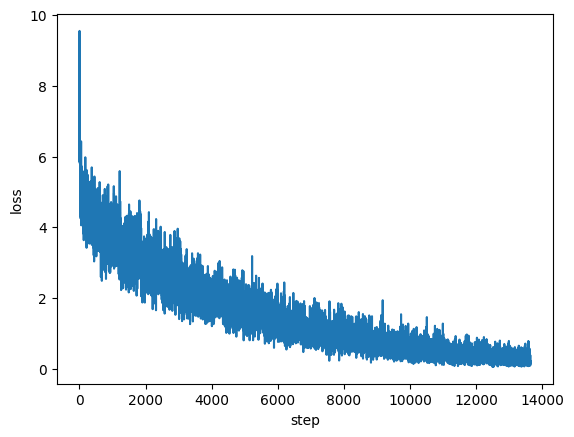

In [ ]:
dataset = 'arc_challenge'
if __name__ == '__main__':

    args_model_path = 't5-base'
    args_choice_num = 4
    args_train_batch_size = 8 # total batch size for training
    args_eval_batch_size = 8 # total batch size for eval
    args_gradient_accumulation_steps = 1 # Number of updates steps to accumulate before performing a backward/update pass
    args_max_len = 256
    args_max_len_gen = 64
    args_lr = 1e-4
    args_epoch_num = 30
    args_num_hidden_layers = 1
    args_alpha = 0.5
    args_beta = 1
    args_seed = 1
    args_external_sent_num = 10
    args_gpu = "0"

   # args = parser.parse_args()
    file_name = f'lr_{args_lr}_seed_{args_seed}_bs_{args_train_batch_size}_ga_{args_gradient_accumulation_steps}_layer_num_{args_num_hidden_layers}_alpha_{args_alpha}_beta_{args_beta}'
    output_model_path = './outputs/' + file_name + "/"
    path_save_result = './results/' + file_name + "/"
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = args_gpu
    os.makedirs(path_save_result, exist_ok=True)
    set_seed(args_seed)
    train_examples = read_dataset("/kaggle/input/openbkqa/train.jsonl")
    dev_examples = read_dataset("/kaggle/input/openbkqa/dev.jsonl")
    test_examples = read_dataset("/kaggle/input/openbkqa/test.jsonl")

#     print(json.dumps({"lr": args.lr, "model": args.model_path, "seed": args.seed,
#                       "bs": args.train_batch_size,
#                       'gradient_accumulation_steps': args.gradient_accumulation_steps,
#                       "epoch": args.epoch_num,
#                       "train_path": args.data_path_train,
#                       "dev_path": args.data_path_dev,
#                       "test_path": args.data_path_test,
#                       "train_size": len(train_examples),
#                       "dev_size": len(dev_examples),
#                       "test_size": len(test_examples),
#                       'num_hidden_layers': args.num_hidden_layers,
#                       'external_sent_num': args.external_sent_num,
#                       "alpha": args.alpha, "beta": args.beta}, indent=2))

    train_batch_size = args_train_batch_size // args_gradient_accumulation_steps
    tokenizer = T5Tokenizer.from_pretrained(args_model_path)
    model = GenMC(args_model_path, args_num_hidden_layers, args_alpha, args_beta)


   # checkpoint = torch.load("/kaggle/input/checkpoints/checkpointspytorch_model.bin", map_location='cpu')
   # model.load_state_dict(checkpoint['model_state_dict'])

#     if args.init_checkpoint is not None:
#         checkpoint = torch.load(args.init_checkpoint, map_location='cpu')
#         model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = torch.optim.AdamW(model.parameters(), lr=args_lr, weight_decay=0.01)

    step_count, step_all, early_stop = 0, 0, 0
    best_dev_rouge_score, best_test_rouge_score = 0, 0
    tr_loss, nb_tr_steps = 0, 0
    print("here1")
    best_dev_acc, _, _ = eval(model, dev_examples, tokenizer, args_eval_batch_size, args_choice_num, args_max_len,
                              args_max_len_gen, args_external_sent_num)
    print('best_dev_acc:',best_dev_acc)
    best_test_acc = 0

    print("here2")
    log = []
    x = []
    y_dev = []
    y_train = []

    for epoch in range(args_epoch_num):
        x.append(epoch)
        early_stop += 1
        order = list(range(len(train_examples)))
        random.seed(args_seed + epoch)
        random.shuffle(order)
        model.train()
        step_count = len(train_examples) // train_batch_size
        if step_count * train_batch_size < len(train_examples):
            step_count += 1
        step_trange = trange(step_count)
        for step in step_trange:
            step_all += 1
            beg_index = step * train_batch_size
            end_index = min((step + 1) * train_batch_size, len(train_examples))
            order_index = order[beg_index:end_index]
            batch_example = [train_examples[index] for index in order_index]
            q_ids, q_mask, qo_ids, qo_mask, clue_ids, clue_content_ids, clue_content_mask, answers, output_clue = get_input_feature(
                batch_example,
                max_source_length=args_max_len,
                max_len_gen=args_max_len_gen,
                choice_num=args_choice_num,
                external_sent_num=args_external_sent_num)
            loss = model(q_ids, q_mask, qo_ids, qo_mask, args_choice_num, clue_ids, clue_content_ids, clue_content_mask, answers)

            loss = loss.mean()
            log.append(loss.item())
            tr_loss += loss.item()
            nb_tr_steps += 1
            loss = loss / args_gradient_accumulation_steps
            loss.backward()
            if (step + 1) % args_gradient_accumulation_steps == 0:
                optimizer.step()
                # scheduler.step()
                optimizer.zero_grad()

            loss_show = ' Epoch:' + str(epoch) + " loss:" + str(round(tr_loss / nb_tr_steps, 4))
            step_trange.set_postfix_str(loss_show)

        train_acc, train_rouge_score, results_dev = eval(model, train_examples, tokenizer, args_eval_batch_size,
                                                     args_choice_num, args_max_len, args_max_len_gen,
                                                     args_external_sent_num)

        dev_acc, dev_rouge_score, results_dev = eval(model, dev_examples, tokenizer, args_eval_batch_size,
                                                     args_choice_num, args_max_len, args_max_len_gen,
                                                     args_external_sent_num)
        print('train_acc', train_acc)
        print('dev_acc:', dev_acc)
        y_dev.append(dev_acc)
        y_train.append(train_acc)

        if dev_acc > best_dev_acc:
            save_dataset(path_save_result + '/dev.csv', results_dev)
            early_stop = 0
            #test_acc, test_rouge_score, results_test = eval(model, test_examples, tokenizer, args_eval_batch_size,
                                                            #args_choice_num, args_max_len, args_max_len_gen,
                                                            #args_external_sent_num)

            #save_dataset(path_save_result + '/test.csv', results_test)
            #best_dev_acc, best_test_acc, best_dev_rouge_score, best_test_rouge_score = dev_acc, test_acc, dev_rouge_score, test_rouge_score
            best_dev_acc,best_dev_rouge_score = dev_acc, dev_rouge_score

            save_model('./checkpoints', model, optimizer)
            print('new best dev acc:', dev_acc, 'rouge:', dev_rouge_score)

        if early_stop >= 10:
            break

    print('best dev acc:', best_dev_acc,
          'best_dev_rouge_score:', best_dev_rouge_score)
    plt.plot(log)
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.show()

Text(0, 0.5, 'loss')

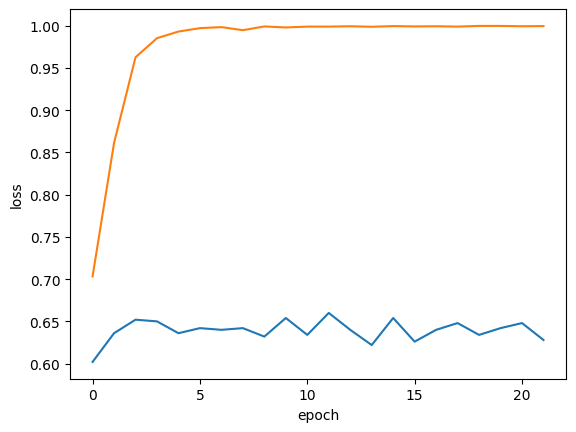

In [ ]:
l1 = plt.plot(x, y_dev, label = 'training loss')
l2 = plt.plot(x, y_train, label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')